The purpose of this project is to create a sentiment analysis algorithm using machine learning with Python. To begin, I'm going to create a Pandas DataFrame using a data set known as the "Polarity Data Set". It is a set of 1,000 positive and 1,000 negative movie reviews. The data is broken down into files in two seperate folders. Each positive review is a .txt file in a 'pos' folder, and each negative review is a file in the 'neg' folder. Both folders are located in a folde named 'txt_sentoken'.

Once the data is structured, I will clean it, play around a little with it, create a pipeline for organizing the data in a way the algorithms will be able to easily read it, and then test which algorithm works the best for classifying the reviews.

Next, I will use BeautifulSoup4 to scrape Yelp.com for some local McDonald's reviews, organize the reviews into a data set, and run the same procedures from the movie data set to see if an algorithm can be trained that holds up to the same accuracy to classify raw data reviews from Yelp.com.

First, I will import what is needed for the first steps of this project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import os

And now I will create the movie review data set.

In [2]:
os.chdir('\\Users\dglover\Desktop')
cwd = os.getcwd()
print(cwd)

pos_rev_folders = os.listdir(str(cwd+'/txt_sentoken/pos/'))
os.chdir('txt_sentoken/pos/')

cwd = os.getcwd()
pos_revs = []
for r in pos_rev_folders:
    with open(r) as f:
        revs = f.read()
        pos_revs.append(revs)
        
pos_df = pd.DataFrame(data=pos_revs)
pos_df['review']=pos_df[0]
pos_df.drop(0, axis=1, inplace=True)
pos_df['sentiment'] = 'pos'
pos_df['sent'] = 1
#pos_df.head()

os.chdir('\\Users\dglover\Desktop')
cwd = os.getcwd()
print(cwd)
os.chdir('txt_sentoken/neg/')
neg_rev_folders = os.listdir(str(cwd+'/txt_sentoken/neg/'))

cwd = os.getcwd()
neg_revs = []
for r in neg_rev_folders:
    with open(r) as f:
        revs = f.read()
        neg_revs.append(revs)
        
neg_df = pd.DataFrame(data=neg_revs)
neg_df['review']=neg_df[0]
neg_df.drop(0, axis=1, inplace=True)
neg_df['sentiment'] = 'neg'
neg_df['sent'] = 0
#neg_df.head()

df = pd.concat([pos_df, neg_df])
#df.head()
df['sent'].value_counts()

C:\Users\dglover\Desktop
C:\Users\dglover\Desktop


1    1000
0    1000
Name: sent, dtype: int64

I'm going to create a few functions to organize and clean the data. For example, I will classify some negations and tokenize the words in the reviews.

In [3]:
import re

pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

In [4]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

In [5]:
def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'

In [6]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=100000):
    data = data.head(n)
    data['review'] = data['review'].progress_map(data_cleaner)  
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

In [7]:
data = post_process(df)

progress-bar: 100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1376.77it/s]


In [8]:
data.head()

,review,sentiment,sent
0,films adapted from comic books have had plenty...,pos,1
1,every now and then a movie comes along from a ...,pos,1
2,you ve got mail works alot better than it dese...,pos,1
3,jaws is a rare film that grabs your attention ...,pos,1
4,moviemaking is a lot like being the general ma...,pos,1


I'm going to play around a bit and make a word cloud for the positive and negative reviews. Let's see if anything sticks out.

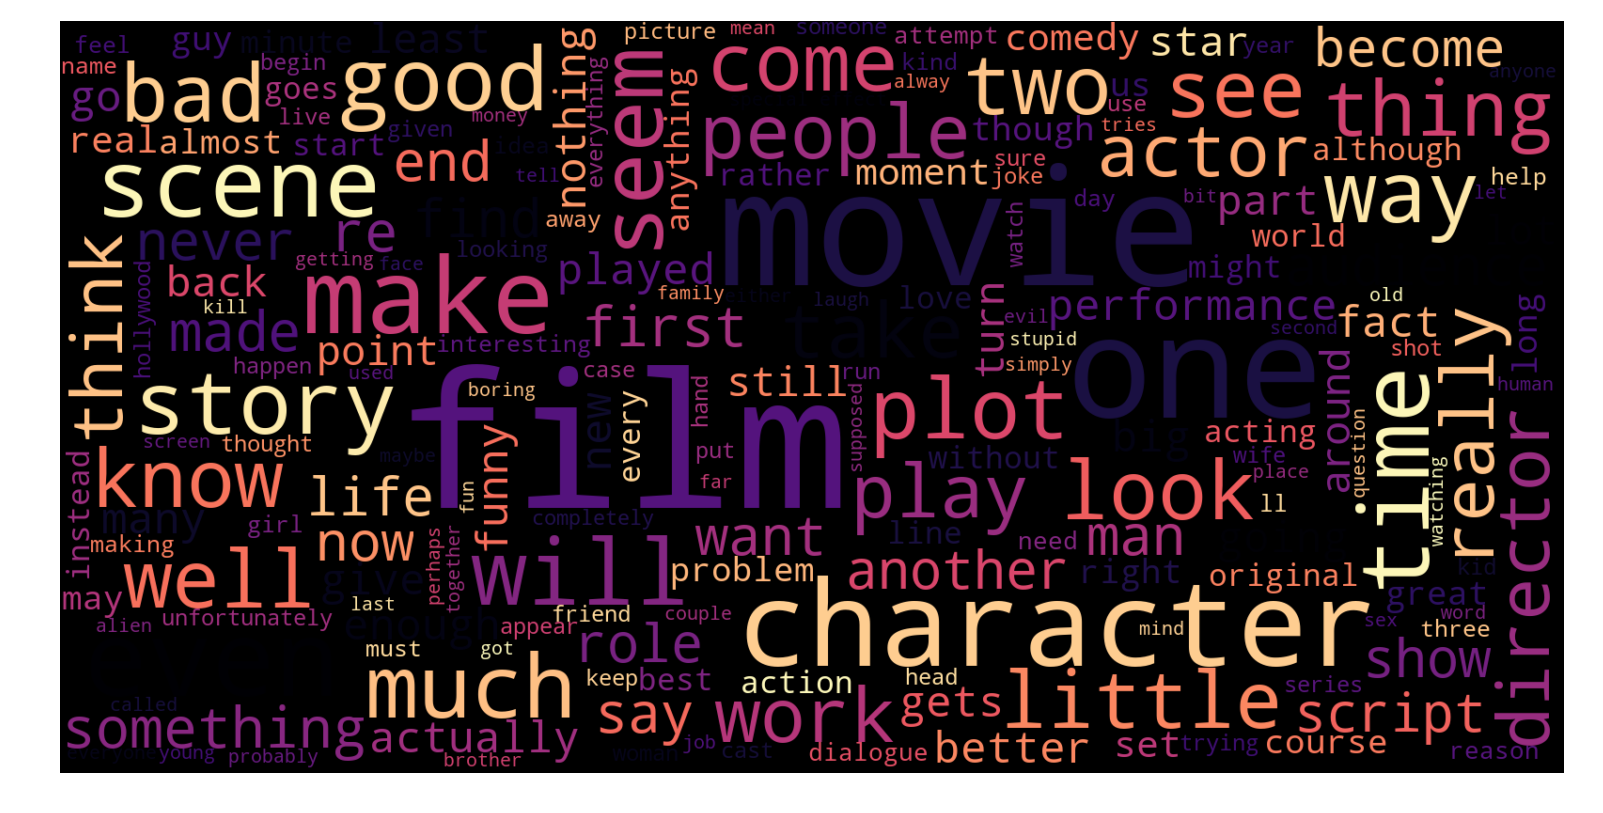

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_rev = data[data.sent == 0]
neg_string = []
for t in neg_rev.review:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

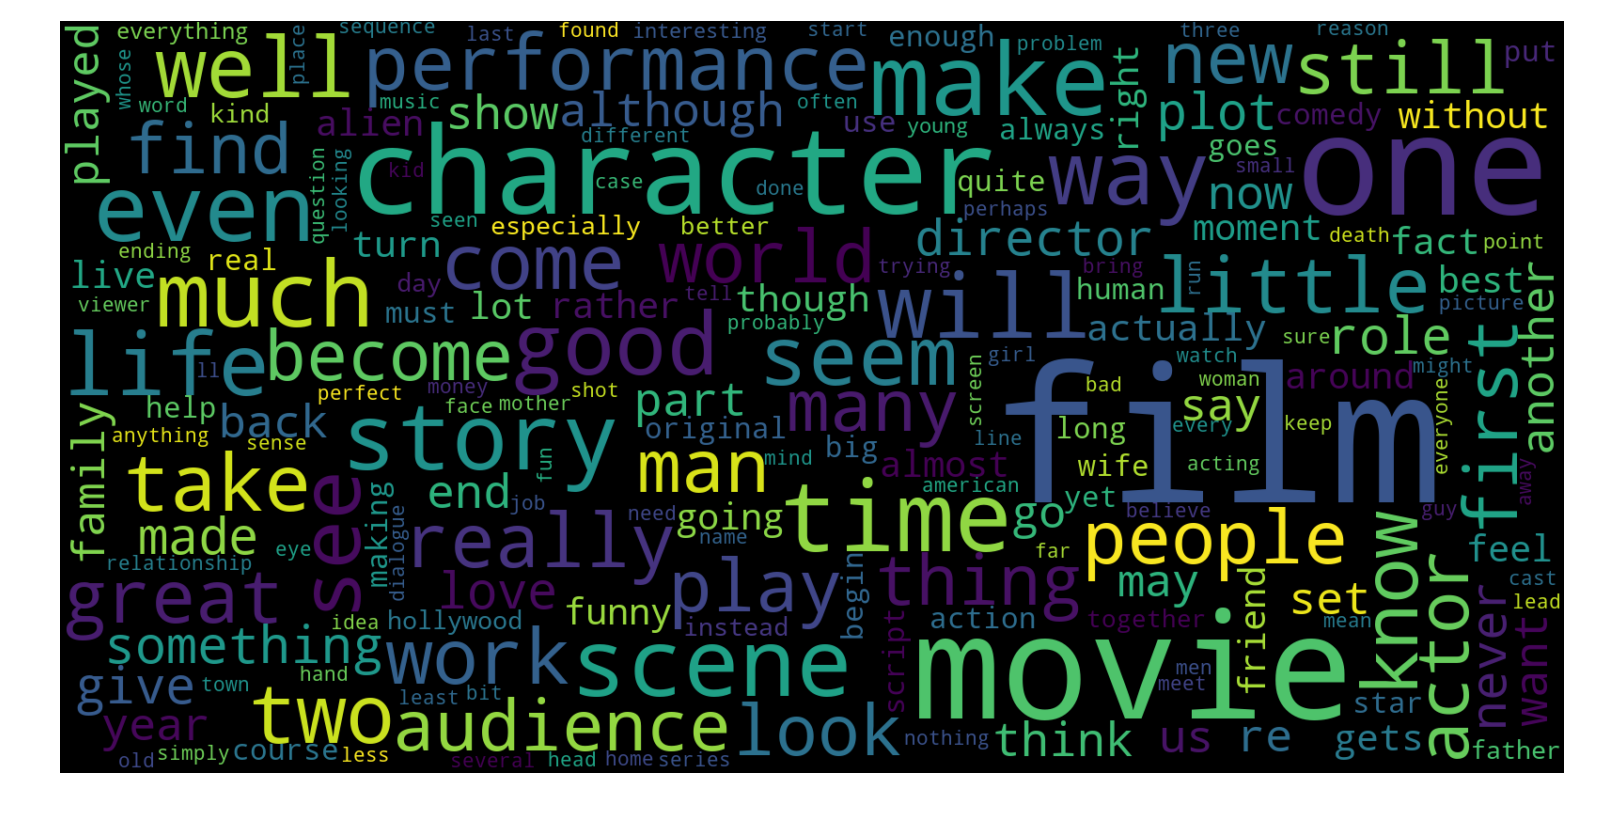

In [10]:
pos_rev = data[data.sent == 1]
pos_string = []
for t in pos_rev.review:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

Time to split the data for training and testing the algorithms.

In [11]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.review, data.sentiment, test_size=.2)

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


I'll create a pipeline and vectorize the data. I'll also create some functions to try multiple algorithms and help determine the best one for our data.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
import numpy as np
from time import time


def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_acc,tt_time = acc_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,clf_acc,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy score: 82.50%
train and test time: 8.98s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
accuracy score: 87.50%
train and test time: 9.14s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, d

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy score: 85.75%
train and test time: 8.76s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy score: 88.00%
train and test time: 8.85s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
accuracy score: 78.50%
train and test time: 8.88s
--------------------------------------------------------------------------------


It looks like I can get some pretty decent results with a few algorithms here. Now that we know we can make predictions with some accuracy, I'll try a similar process on some raw data from the web. I'll use beautifulsoup to scrape some reviews of local McDonald's from Yelp.com.

In [15]:
import urllib
from bs4 import BeautifulSoup

urls = ['https://www.yelp.com/biz/mcdonalds-new-york-105',
        'https://www.yelp.com/biz/mcdonalds-new-york-86',
        'https://www.yelp.com/biz/mcdonalds-new-york-386',
        'https://www.yelp.com/biz/mcdonalds-new-york-110',
        'https://www.yelp.com/biz/mcdonalds-new-york-146',
        'https://www.yelp.com/biz/mcdonalds-new-york-150',
        'https://www.yelp.com/biz/mcdonalds-new-york-107',
        'https://www.yelp.com/biz/mcdonalds-new-york-124',
        'https://www.yelp.com/biz/mcdonalds-new-york-427',
        'https://www.yelp.com/biz/mcdonalds-new-york-388']

ratings =[]
reviews =[]

for url in urls:
    start = 0
    num_pages = 5
    end = 20* num_pages

    while (start < end):
        ur = url + '?start=' + str(start)
        start +=20
        print(ur)

        page = urllib.request.urlopen(ur)
        soup = BeautifulSoup(page)

    
        for reviewBody in soup.findAll('div',{"class":"review-content"}):
            ratings.append(reviewBody.div.div.div.get("title"))
            reviews.append(reviewBody.find('p').text)
    print(ratings)
    #print reviews

https://www.yelp.com/biz/mcdonalds-new-york-105?start=0


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-105?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-105?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-105?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-105?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-86?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-86?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-86?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-86?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-386?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-386?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-386?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-386?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-110?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-110?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-110?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-110?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-146?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-146?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-146?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-146?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-150?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-150?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-150?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-150?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-107?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-107?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-107?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-107?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r


https://www.yelp.com/biz/mcdonalds-new-york-124?start=0


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-124?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-124?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-124?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-124?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r


https://www.yelp.com/biz/mcdonalds-new-york-427?start=0


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-427?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-427?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-427?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-427?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r


https://www.yelp.com/biz/mcdonalds-new-york-388?start=0


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-388?start=20


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-388?start=40


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-388?start=60


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


https://www.yelp.com/biz/mcdonalds-new-york-388?start=80


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['3.0 star rating', '1.0 star rating', '2.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '1.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '4.0 star rating', '1.0 star rating', '1.0 star rating', '2.0 star rating', '5.0 star rating', '4.0 star rating', '3.0 star rating', '1.0 star rating', '1.0 star rating', '3.0 star r

In [16]:
df = pd.DataFrame()

df['rating']=ratings
df['review']=reviews

ratings1=[]
for rating in df['rating']:
    ratings1.append(int(rating[:1]))

df['rating']= ratings1
df.head()

#df.to_csv("E:\yelp Reviews\\reviews.csv", encoding='utf-8')

,rating,review
0,3,"revamped/renovated McDonalds, a while back. st..."
1,1,Running around between appointments. I ran in...
2,2,"I am not a morning person, but I had to be at ..."
3,2,Perhaps one of the shittiest MickeyDs in the a...
4,1,It's bad enough that I have to review a Mc Don...


In [17]:
df['sentiment'] = np.where(df['rating']>=4, 1, 0)
df = df[df['rating']!=3]
df.head()

,rating,review,sentiment
1,1,Running around between appointments. I ran in...,0
2,2,"I am not a morning person, but I had to be at ...",0
3,2,Perhaps one of the shittiest MickeyDs in the a...,0
4,1,It's bad enough that I have to review a Mc Don...,0
5,1,Came here after going to the local AMC and it ...,0


In [18]:
data = post_process(df)

progress-bar: 100%|████████████████████████████████████████████████████████████████| 534/534 [00:00<00:00, 7977.60it/s]


In [19]:
data.head()

,rating,review,sentiment
0,1,running around between appointments i ran in h...,0
1,2,i am not a morning person but i had to be at u...,0
2,2,perhaps one of the shittiest mickeyds in the a...,0
3,1,it s bad enough that i have to review a mc don...,0
4,1,came here after going to the local amc and it ...,0


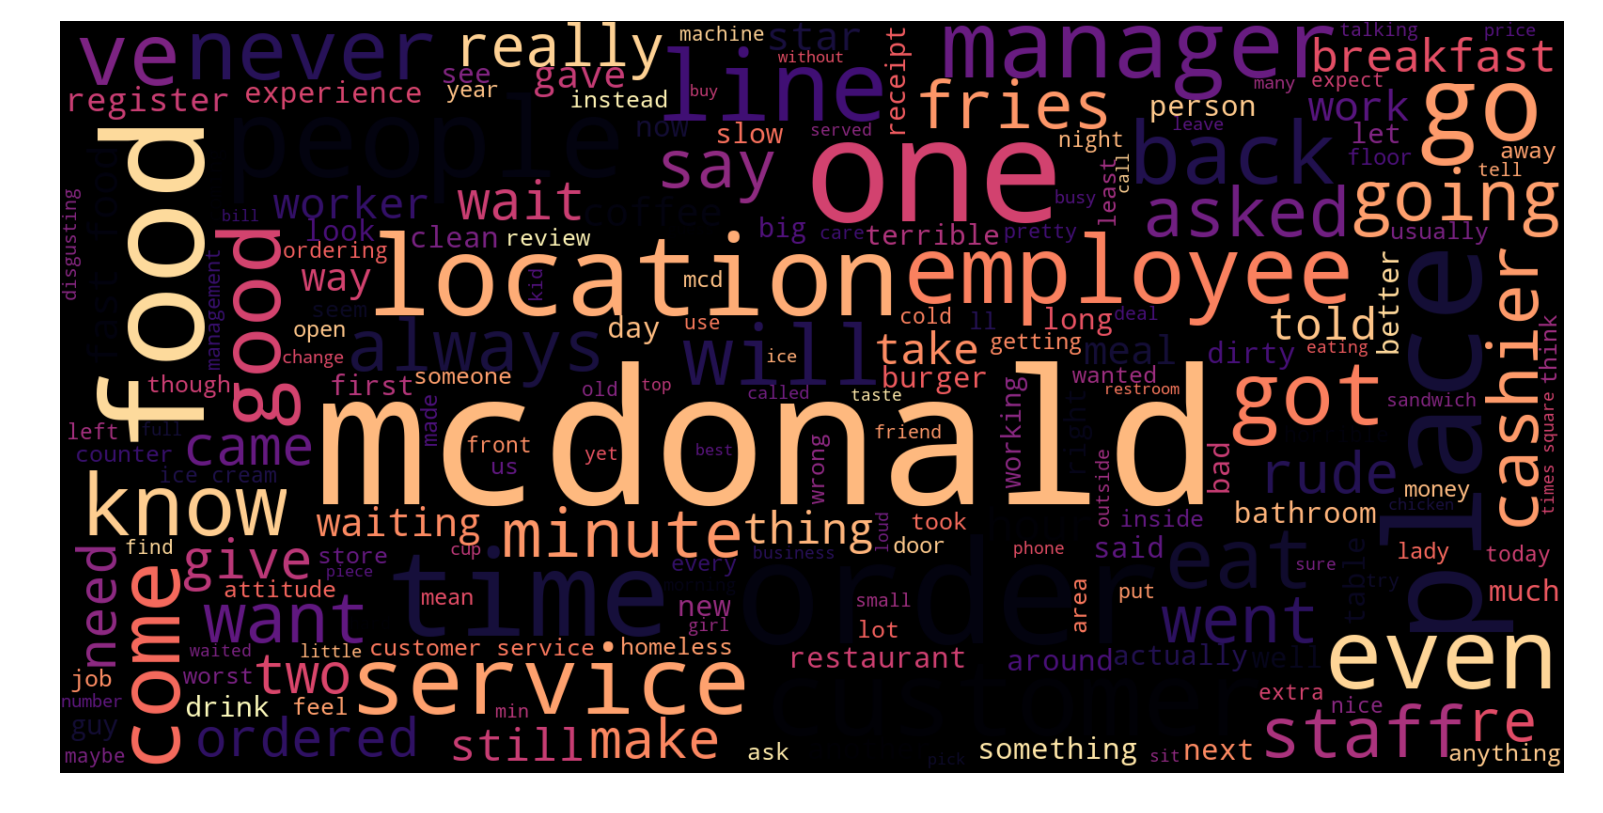

In [20]:
neg_rev = data[data.sentiment == 0]
neg_string = []
for t in neg_rev.review:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


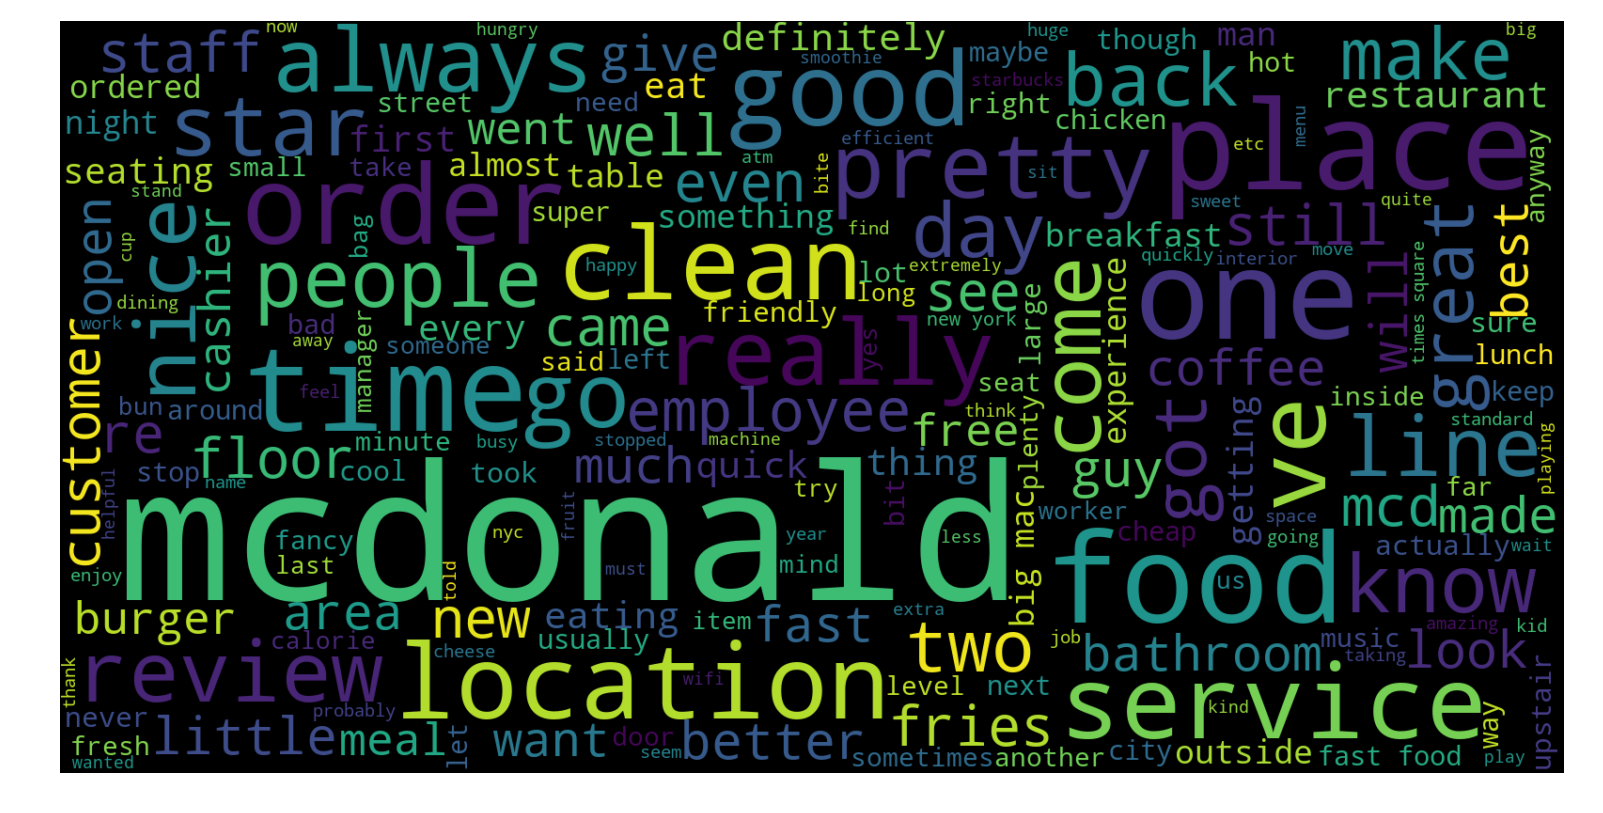

In [21]:
pos_rev = data[data.sentiment == 1]
pos_string = []
for t in pos_rev.review:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data.review, data.sentiment, test_size=.25)

In [23]:
def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [24]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

In [25]:
tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_acc,tt_time = acc_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,clf_acc,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy score: 77.61%
train and test time: 0.35s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
accuracy score: 80.60%
train and test time: 0.33s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, d

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy score: 80.60%
train and test time: 0.30s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy score: 82.84%
train and test time: 0.35s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
accuracy score: 83.58%
train and test time: 0.31s
--------------------------------------------------------------------------------


Looks like the accuracy holds up pretty well. It's nothing state of the art, but it can predict raw reviews from the web with >80%, which isn't bad.

I'll create another pipeline to feed new data to the algorith with the best results so that we can test it out.

In [26]:
pipe = Pipeline([('vectorizer', tvec),('classifier', PassiveAggressiveClassifier())])

In [27]:
pipe.fit(X_train, y_train)

C:\Users\dglover\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=...   n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False))])

In [28]:
new = [X_test.iloc[20]]
pipe.predict(new)

array([0])

In [29]:
new

['it s bad enough that i have to review a mc donald s on yelp overall oily tables beggars asking for change as you eat people that did not even order were loitering throughout the restaurant marijuana residue on my table specifically supposedly no bathrooms only registers were open out of on thursday afternoon at p m']

In [30]:
pipe.score(X=X_test, y=y_test)

0.8283582089552238

Looks like it works for this example, and the accuracy holds true to what we've seen above.